In [1]:
%pylab inline
import seaborn as sns
import numpy as np
import pandas as pd
import cPickle as pickle
from irm import cvpipelineutil
import sklearn.neighbors
import scipy.sparse
import irm
import os
sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


In [2]:
td = lambda x: os.path.join("../data/", x)
neurons_data = pickle.load(open(td("mushroombody.neurondf.pickle"), 'r'))
synapse_data = pickle.load(open(td("mushroombody.synapsesdf.pickle"), 'r'))
basicmat_data = pickle.load(open(td("mushroombody.cleandata.pickle"), 'r'))
kc_mbon_rosettes = pickle.load(open(td('mushroombody.KC-MBON.rosette.df.pickle'), 'r'))
rosette_df = kc_mbon_rosettes['rosette_df']
tbar_df = synapse_data['tbar_df']
connections_df = synapse_data['connections_df']
neurons_df = neurons_data['neurondf']

d = pickle.load(open(td("mushroombody.KC-rosette-KC.mats.pickle"), 'r'))

a = d['all_results'][(20, True)]
kc_kc_mats = a['kc_kc_mats']
kc_rosette_kc_mats = a['kc_rosette_kc_mats']
pre_ids_names_sorted = d['pre_ids_names_sorted']
pre_ids_to_pos = d['pre_ids_to_pos']


In [3]:
pos_to_pre_ids = {v :k for k, v in pre_ids_to_pos.iteritems()}

In [16]:
d = pickle.load(open(td("mushroombody.KC-rosette-KC.mats.pickle"), 'r'))

a = d['all_results'][(20, True)]
kc_kc_mats = a['kc_kc_mats']
kc_rosette_kc_mats = a['kc_rosette_kc_mats']
kc_rosette_kc_mats.keys()
MBON_NAMES = kc_rosette_kc_mats.keys()

In [17]:

sort_order = d['sort_order']
KCN = len(sort_order)

In [18]:
# load samples
mbon_chains = {}
for tgt_cell in MBON_NAMES:
    mbon_name = tgt_cell
    samples = [pickle.load(open(td("KC-rosette-KC.%s.samples.%02d.pickle" %(tgt_cell, i)))) for i in range(10)]

    mbon_chains[tgt_cell] = [s['samples'][tgt_cell][1] for s in samples]

In [8]:
def get_by_pre_id(id):
    rows = neurons_df[neurons_df['body ID'] == id]
    if len(rows) == 0:
        raise Exception("unknown body id")
    return rows.iloc[0]


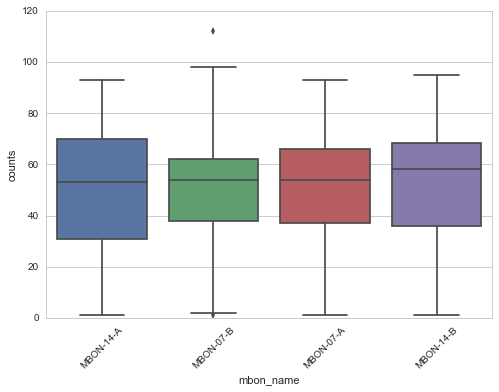

In [35]:
res = []
for mbon_name, chains in mbon_chains.iteritems():


    av = [irm.util.canonicalize_assignment(np.array(d['domains']['d1']['assignment'])) for d in chains]
    for ai, a in enumerate(av):
        counts = irm.util.assign_to_counts(a)
        df = pd.DataFrame({'counts' : counts})
        df['ai'] = ai
        df['mbon_name'] = mbon_name
        res.append(df)
df = pd.concat(res)
df = df[df.mbon_name.isin(['MBON-14-A', 'MBON-14-B', 'MBON-07-A', 'MBON-07-B'])]
a = sns.boxplot(x='mbon_name', y='counts', data=df)
for item in a.get_xticklabels():
    item.set_rotation(45)

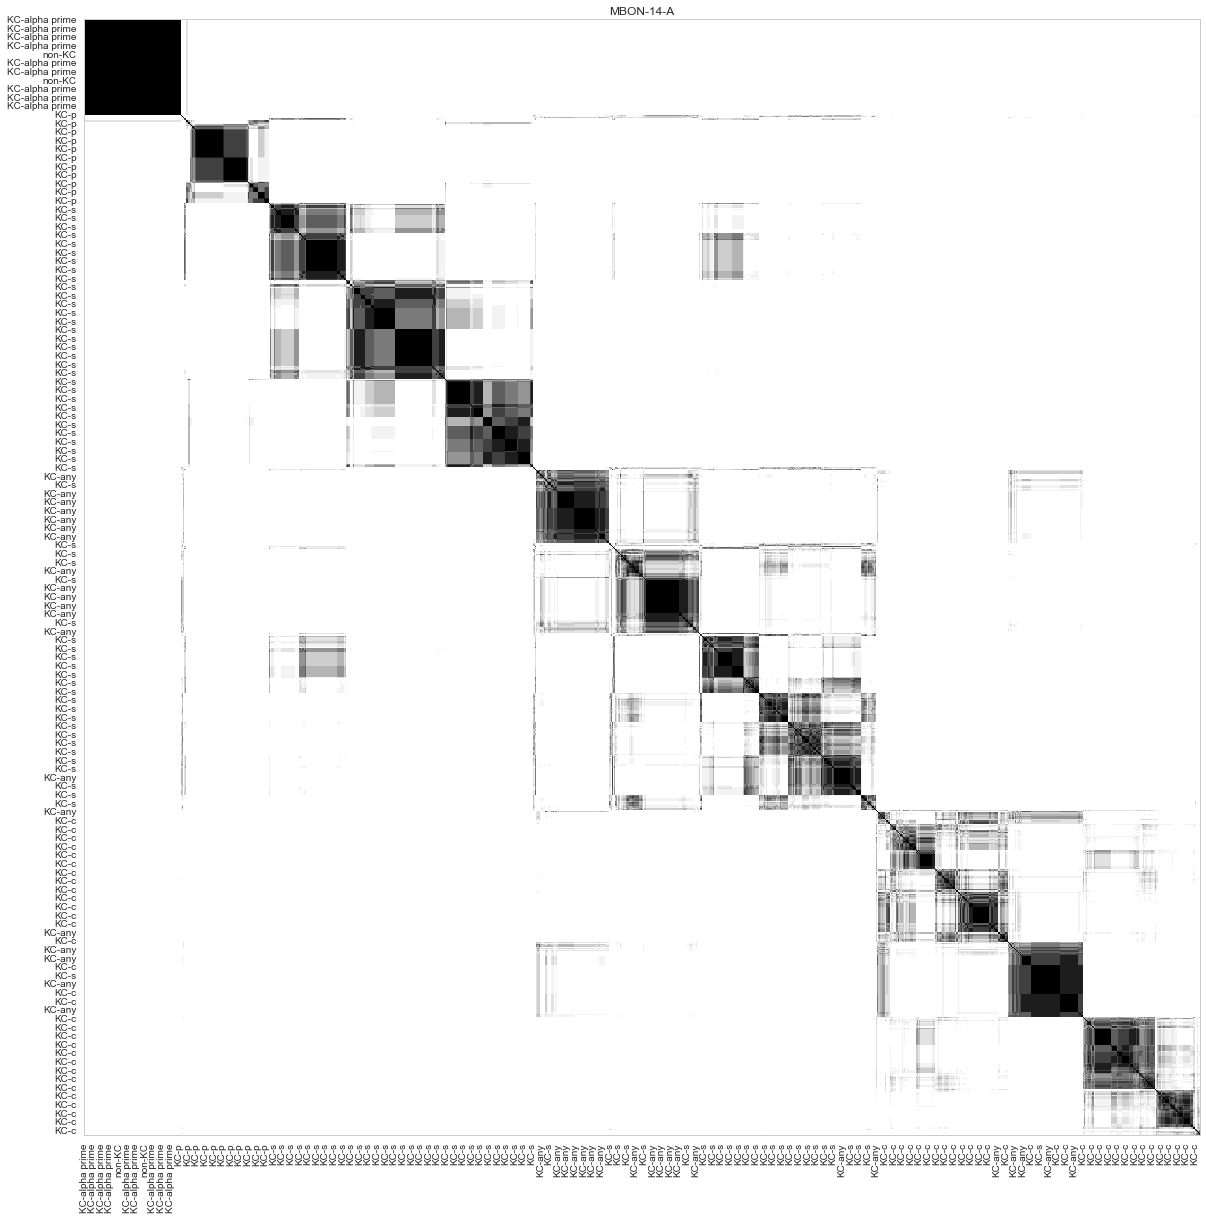

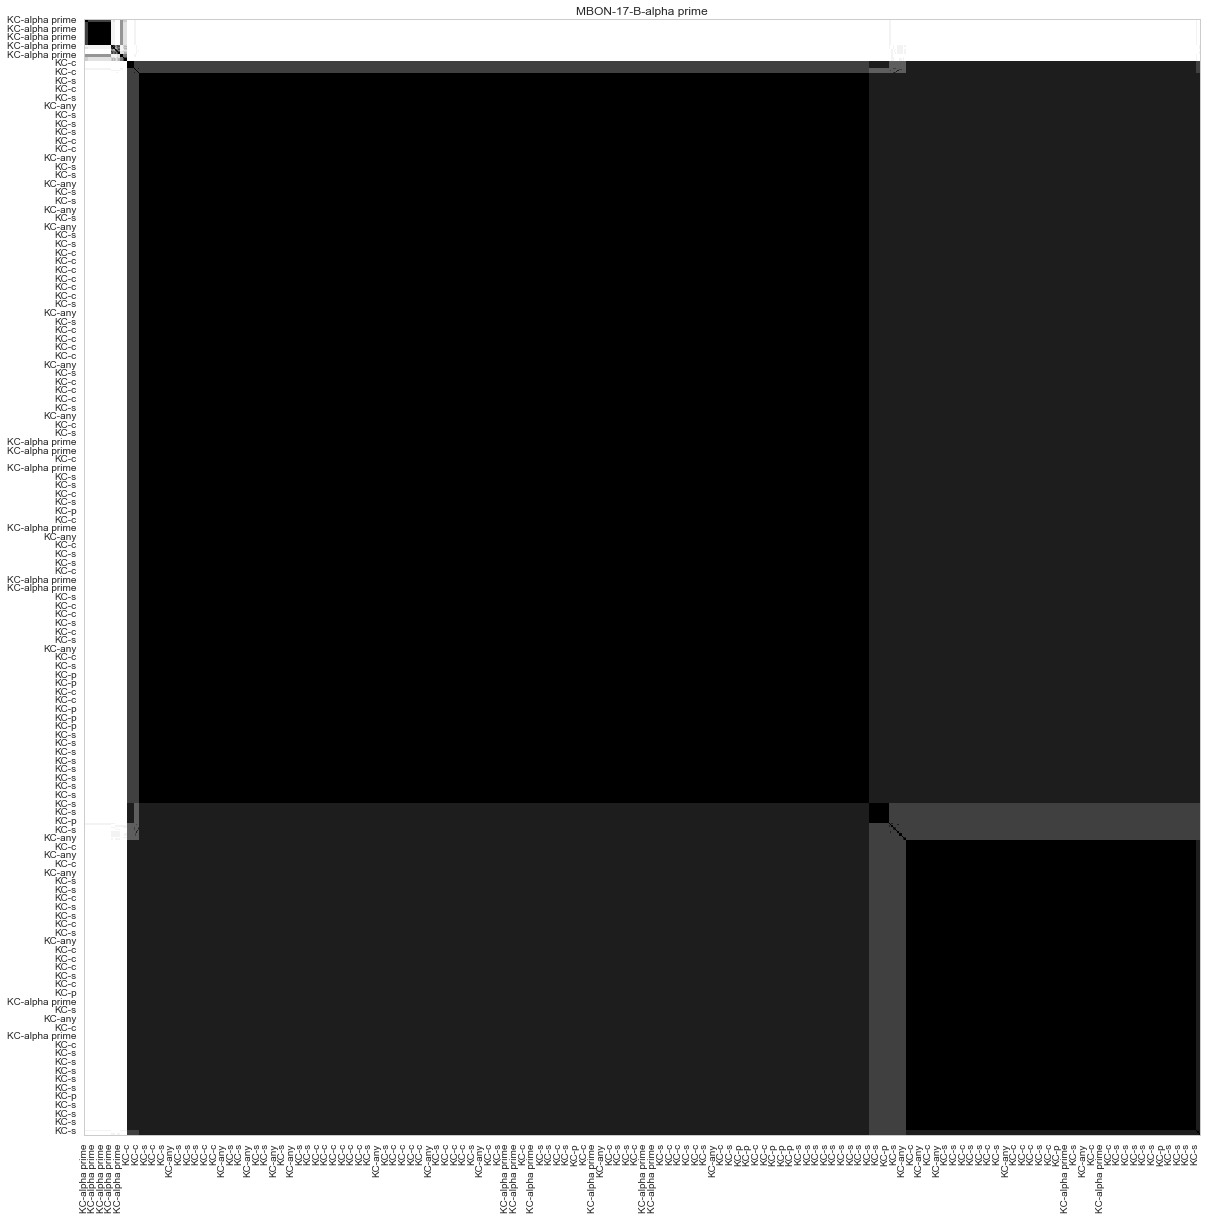

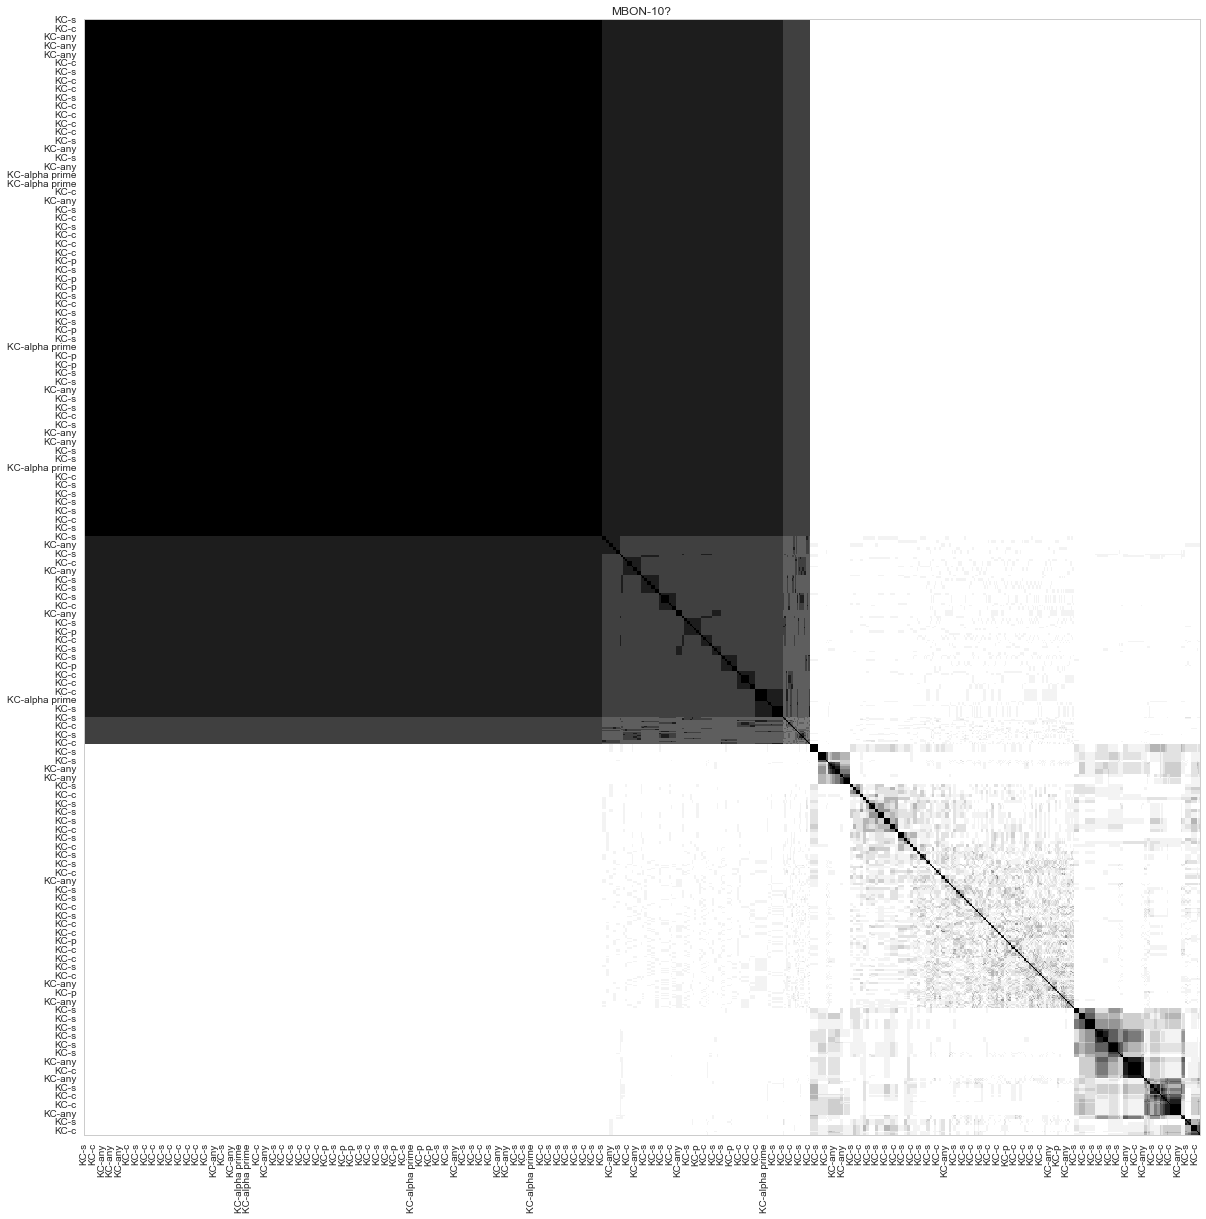

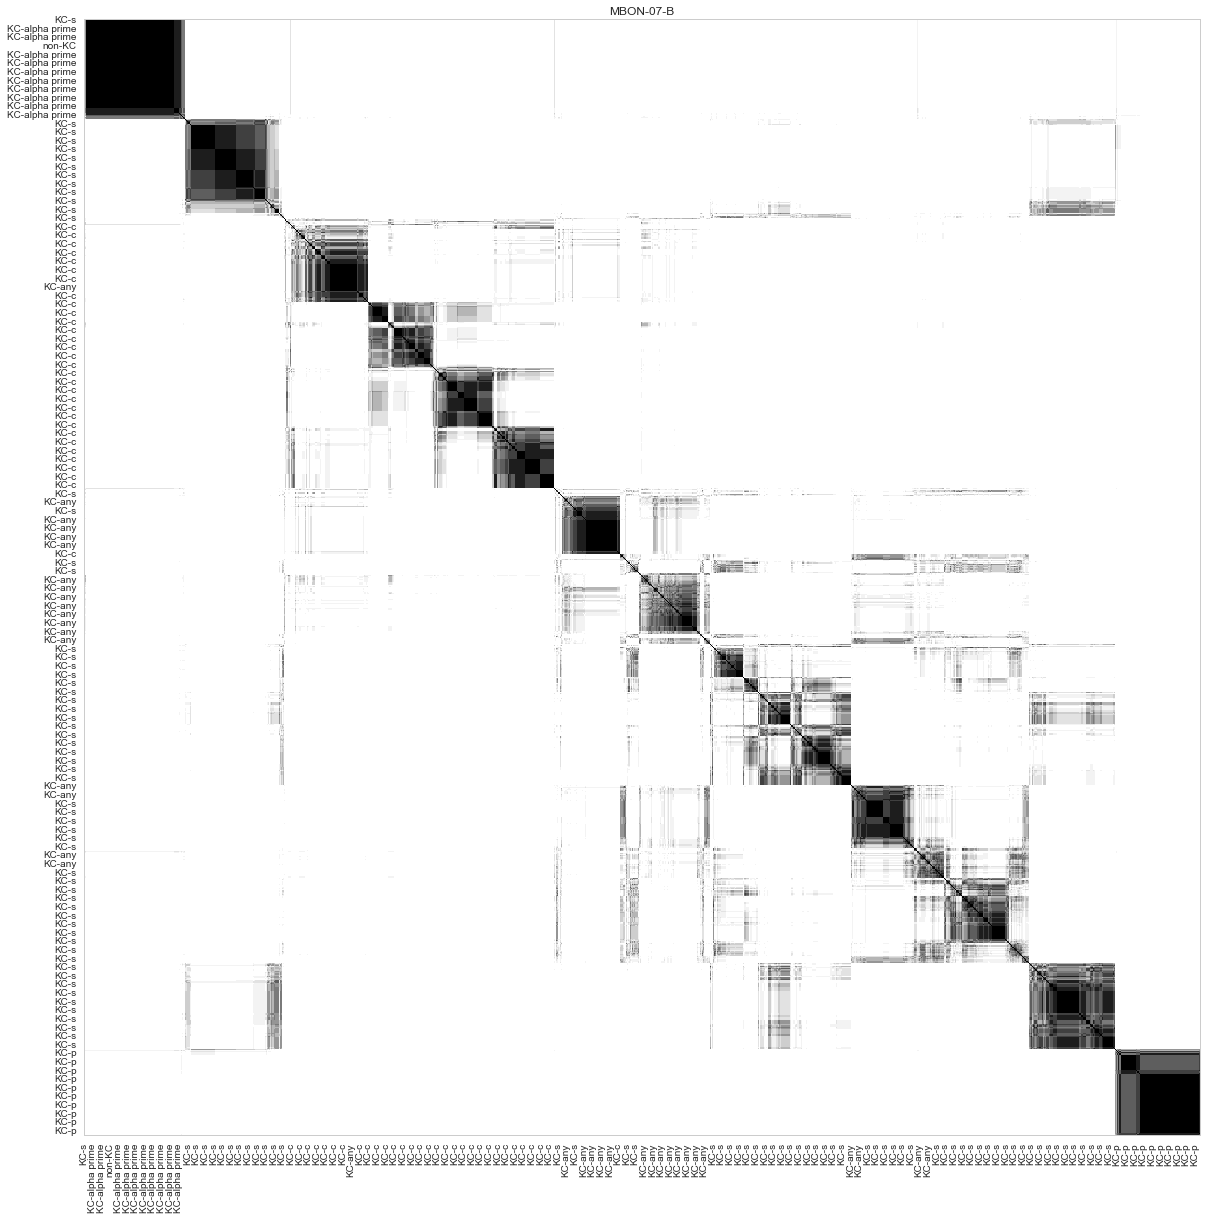

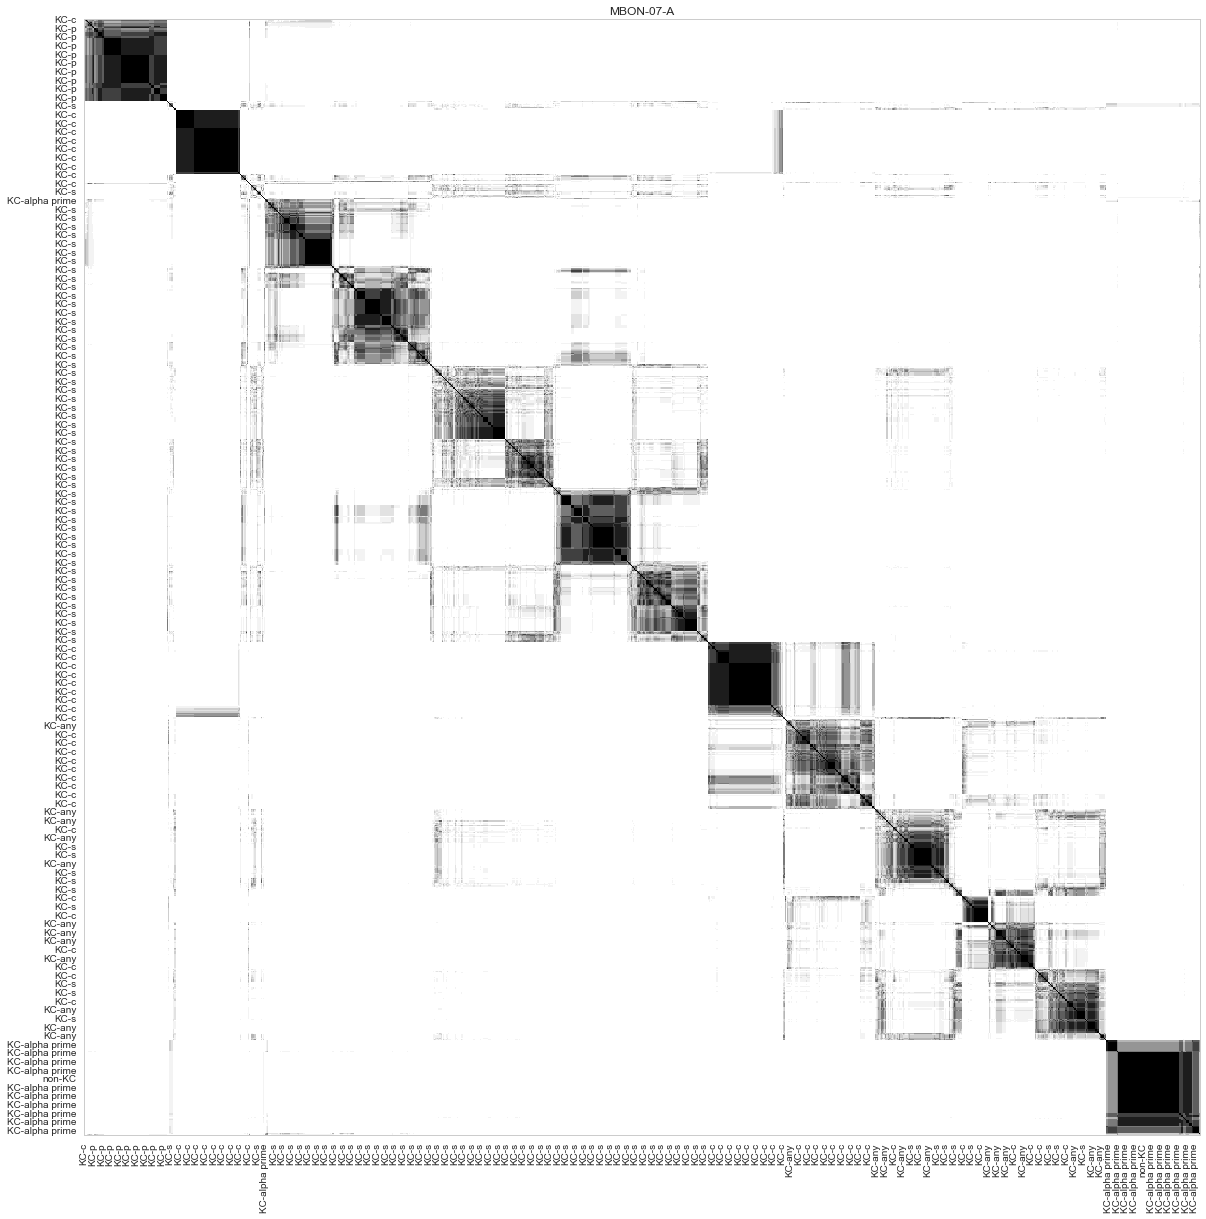

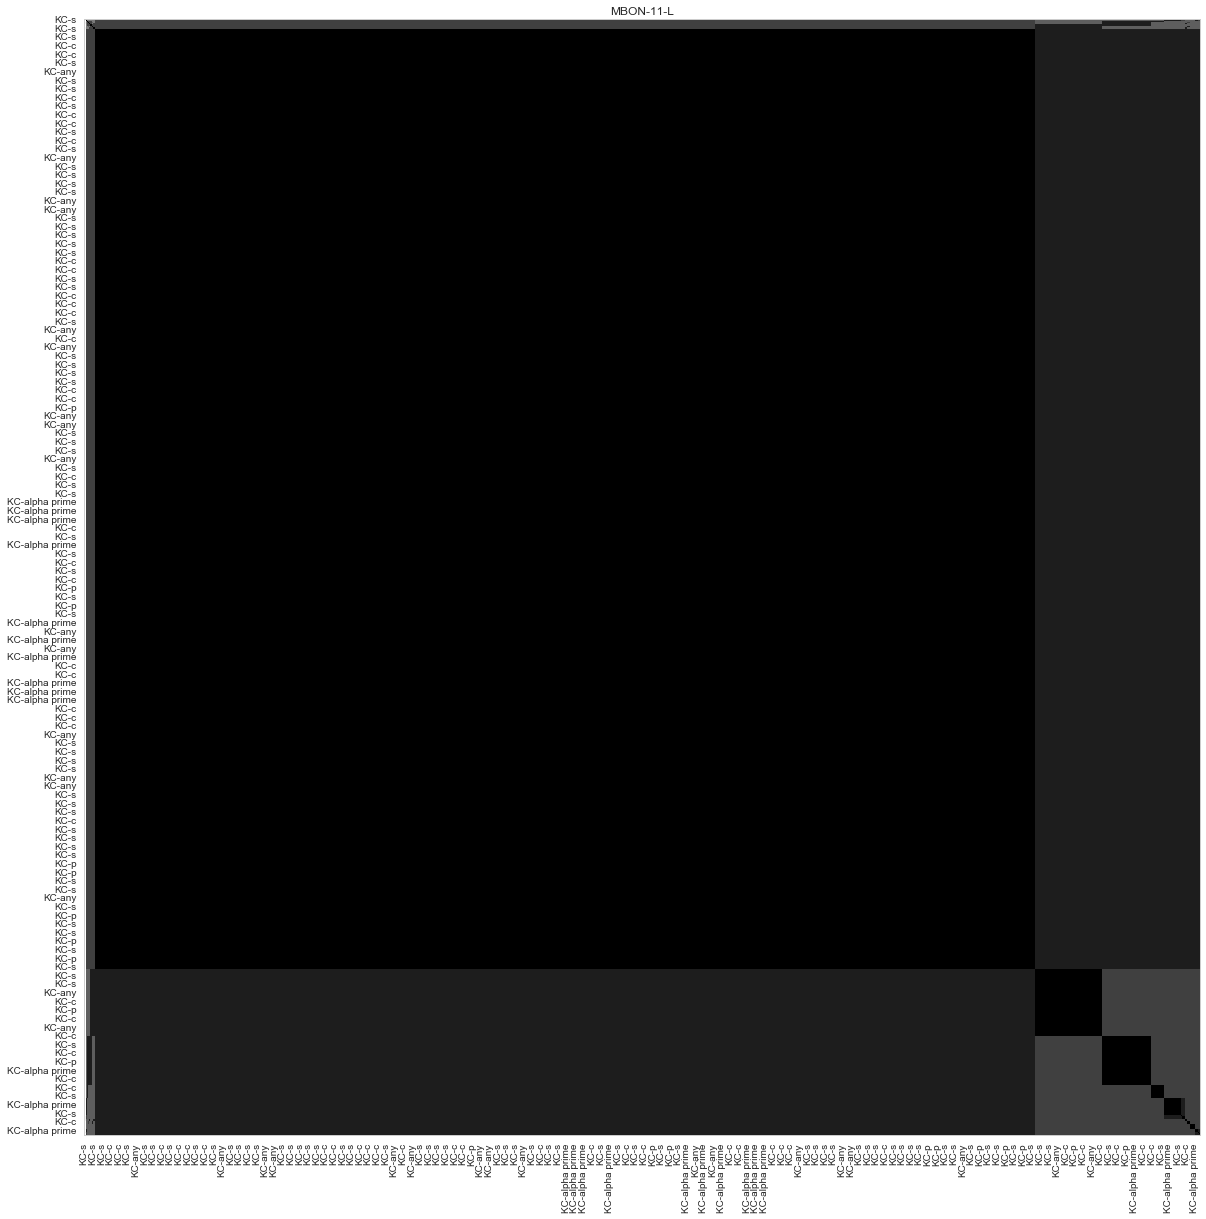

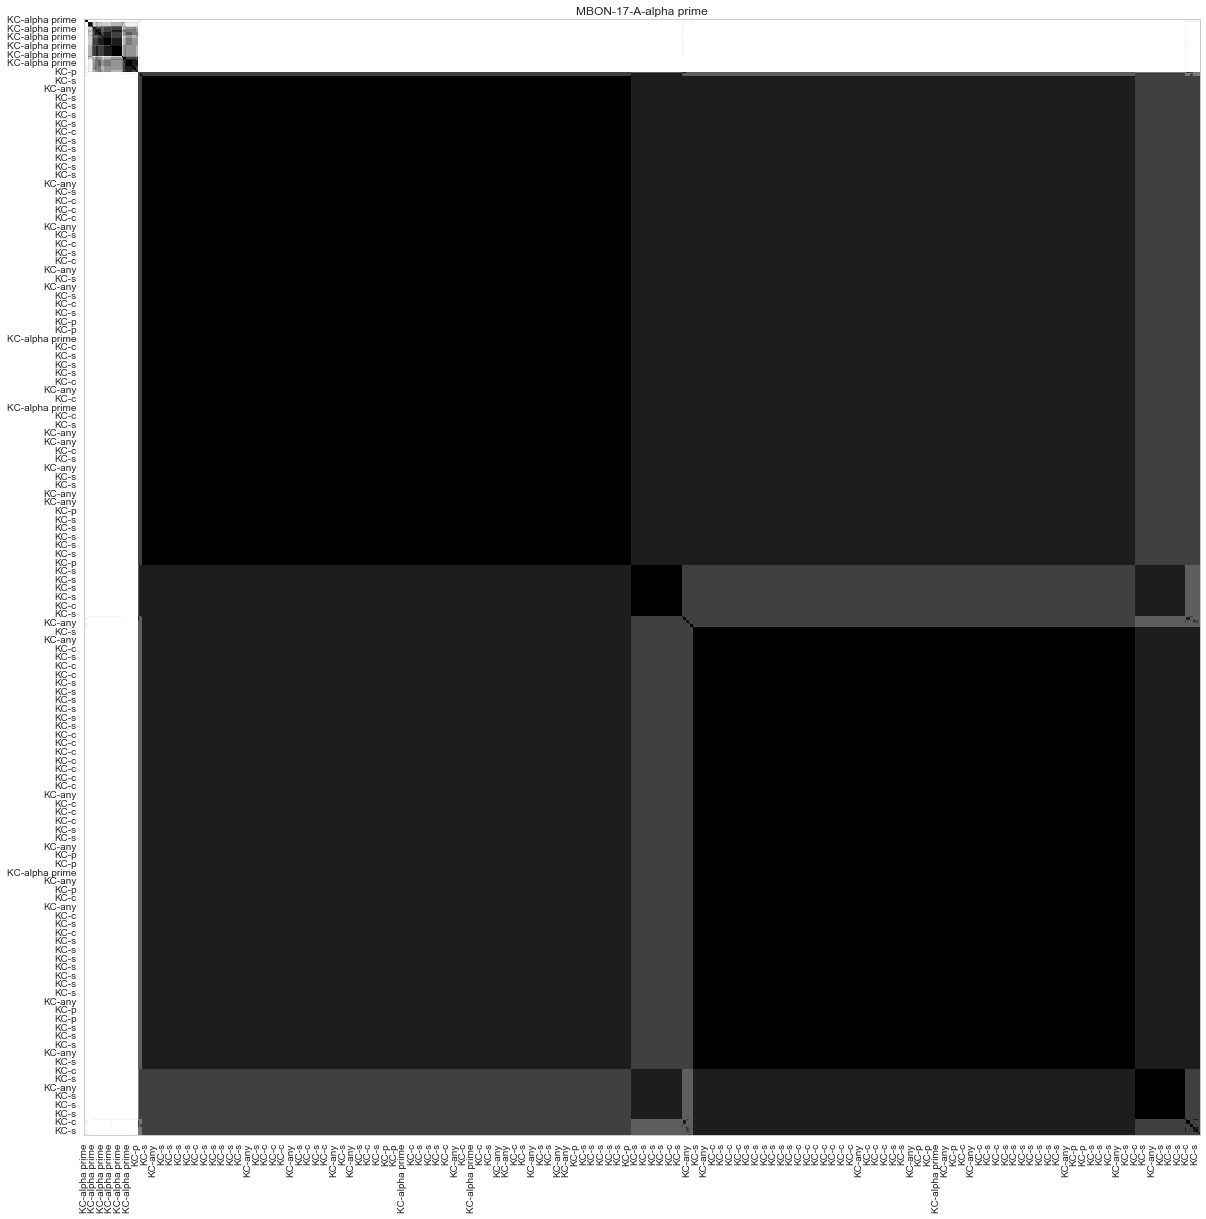

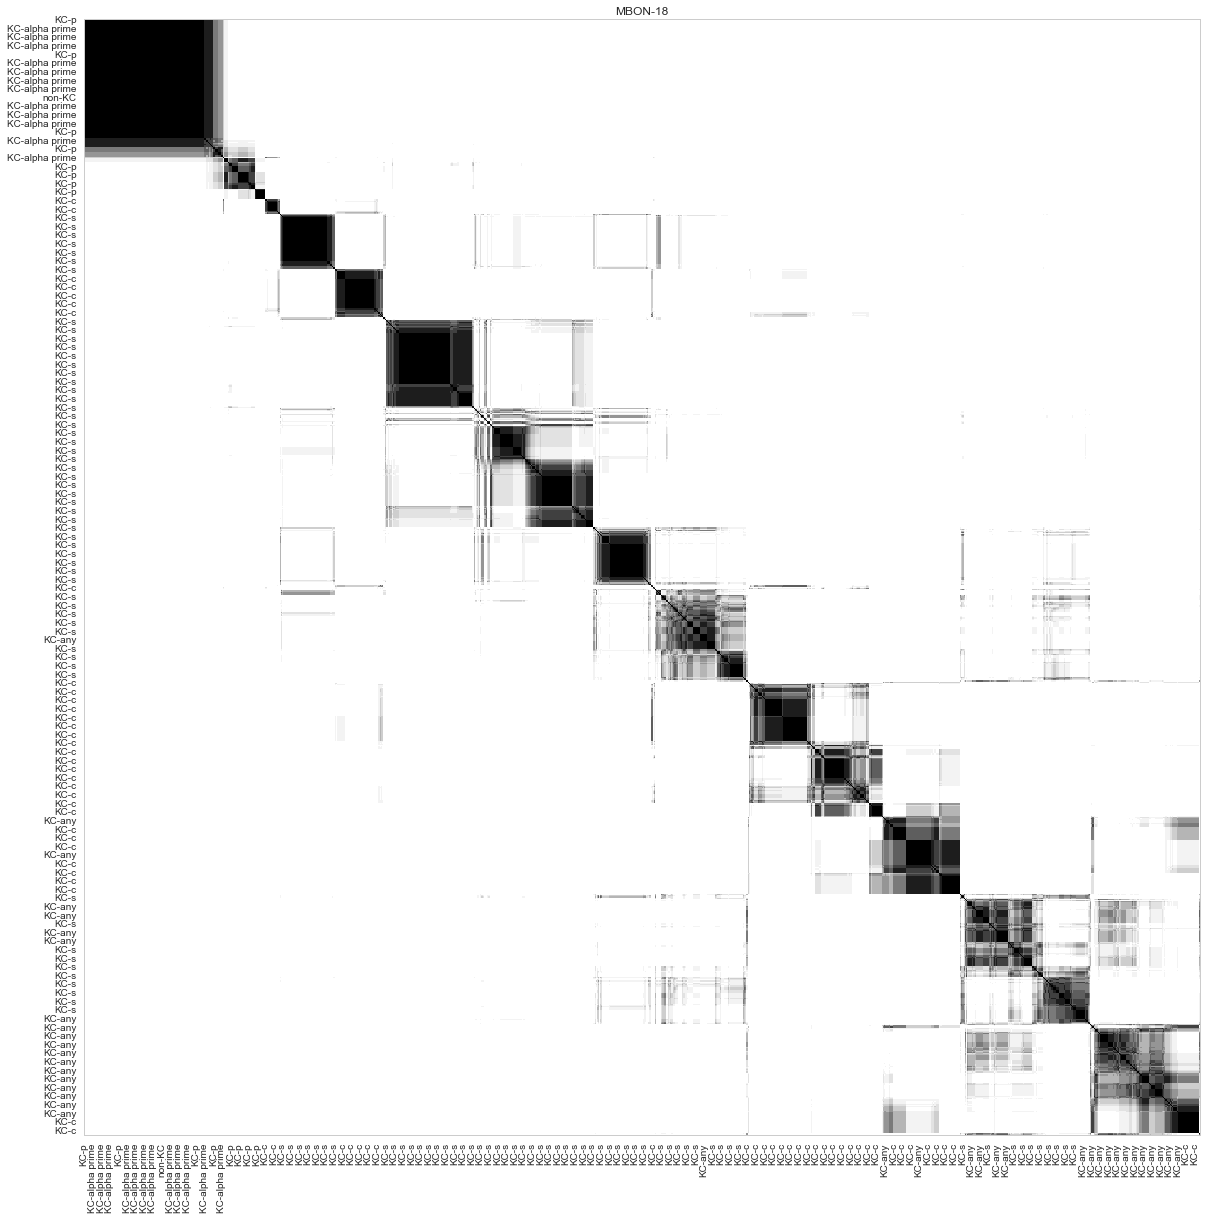

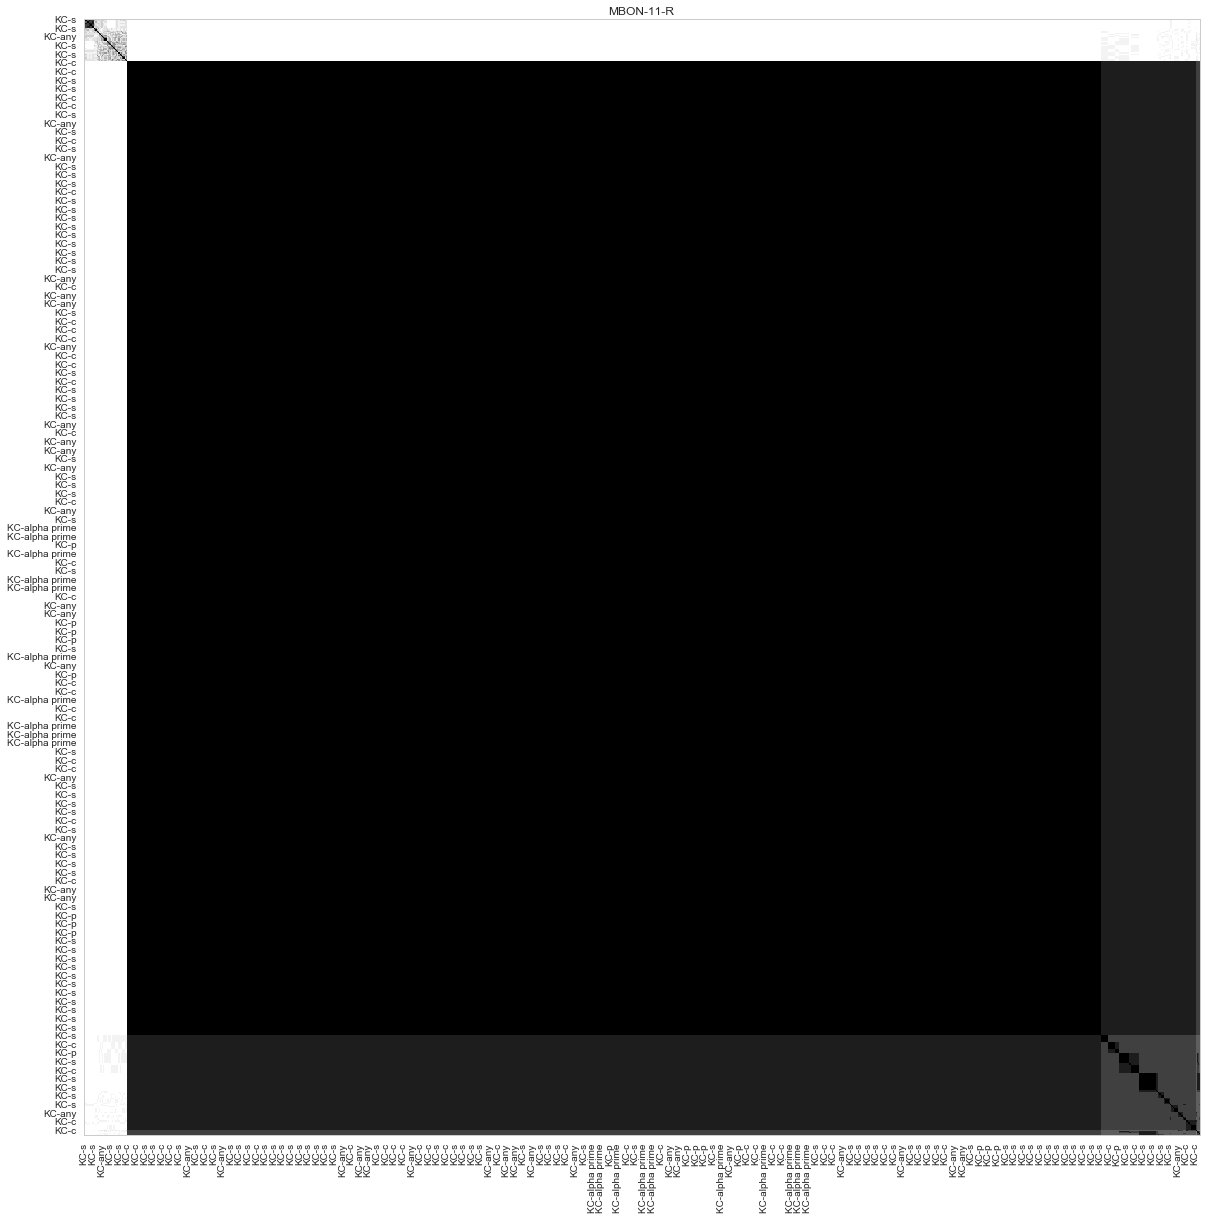

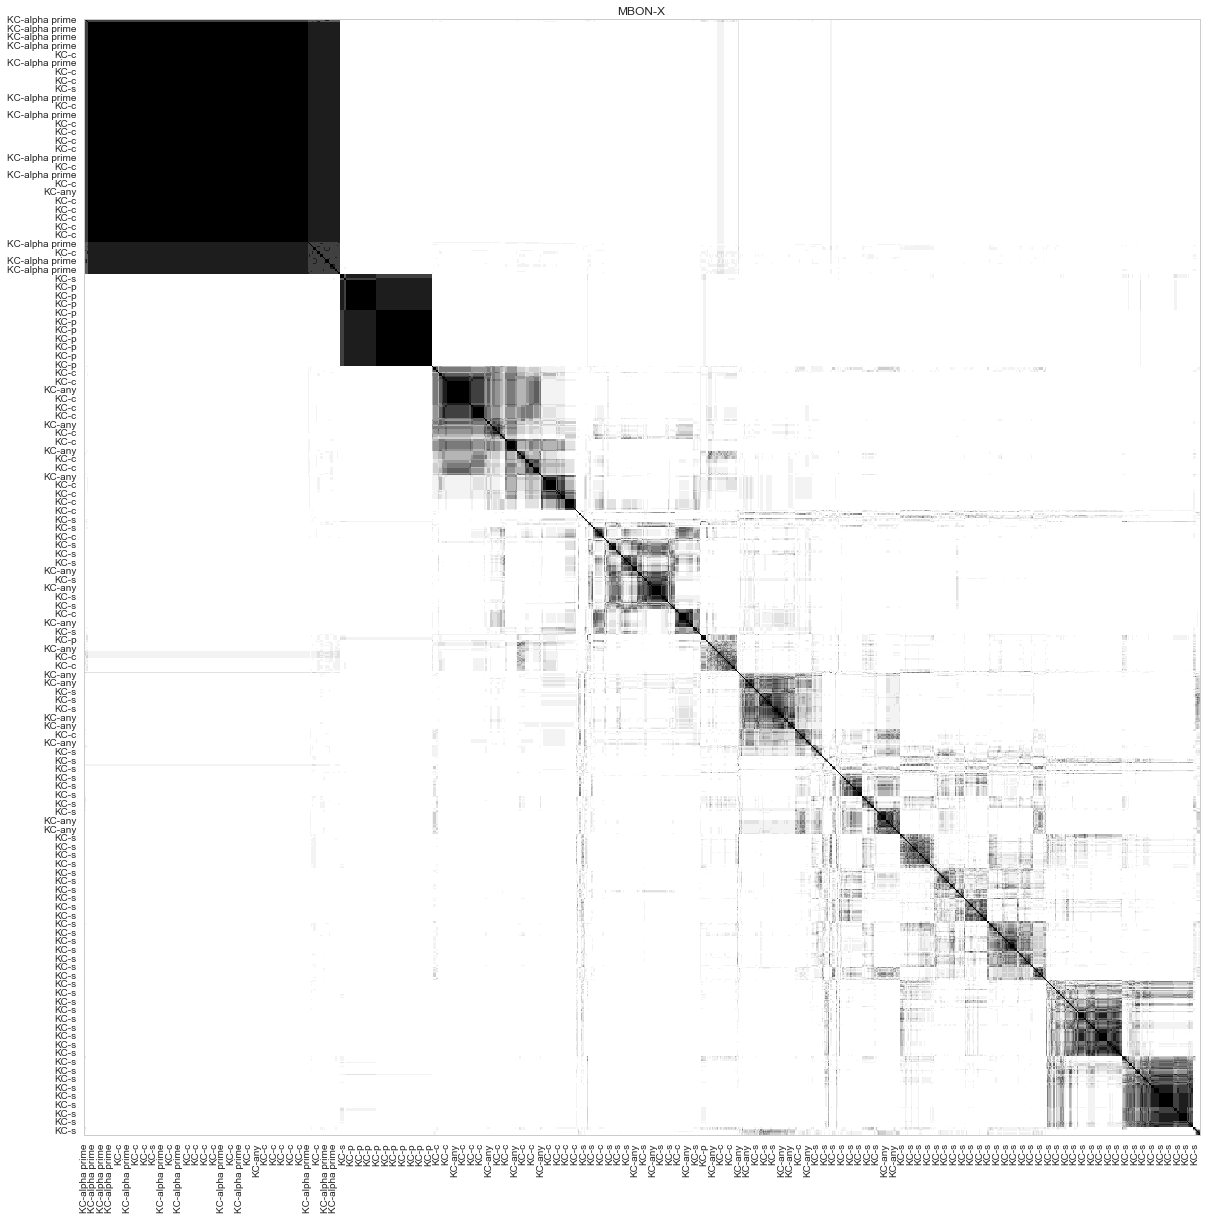

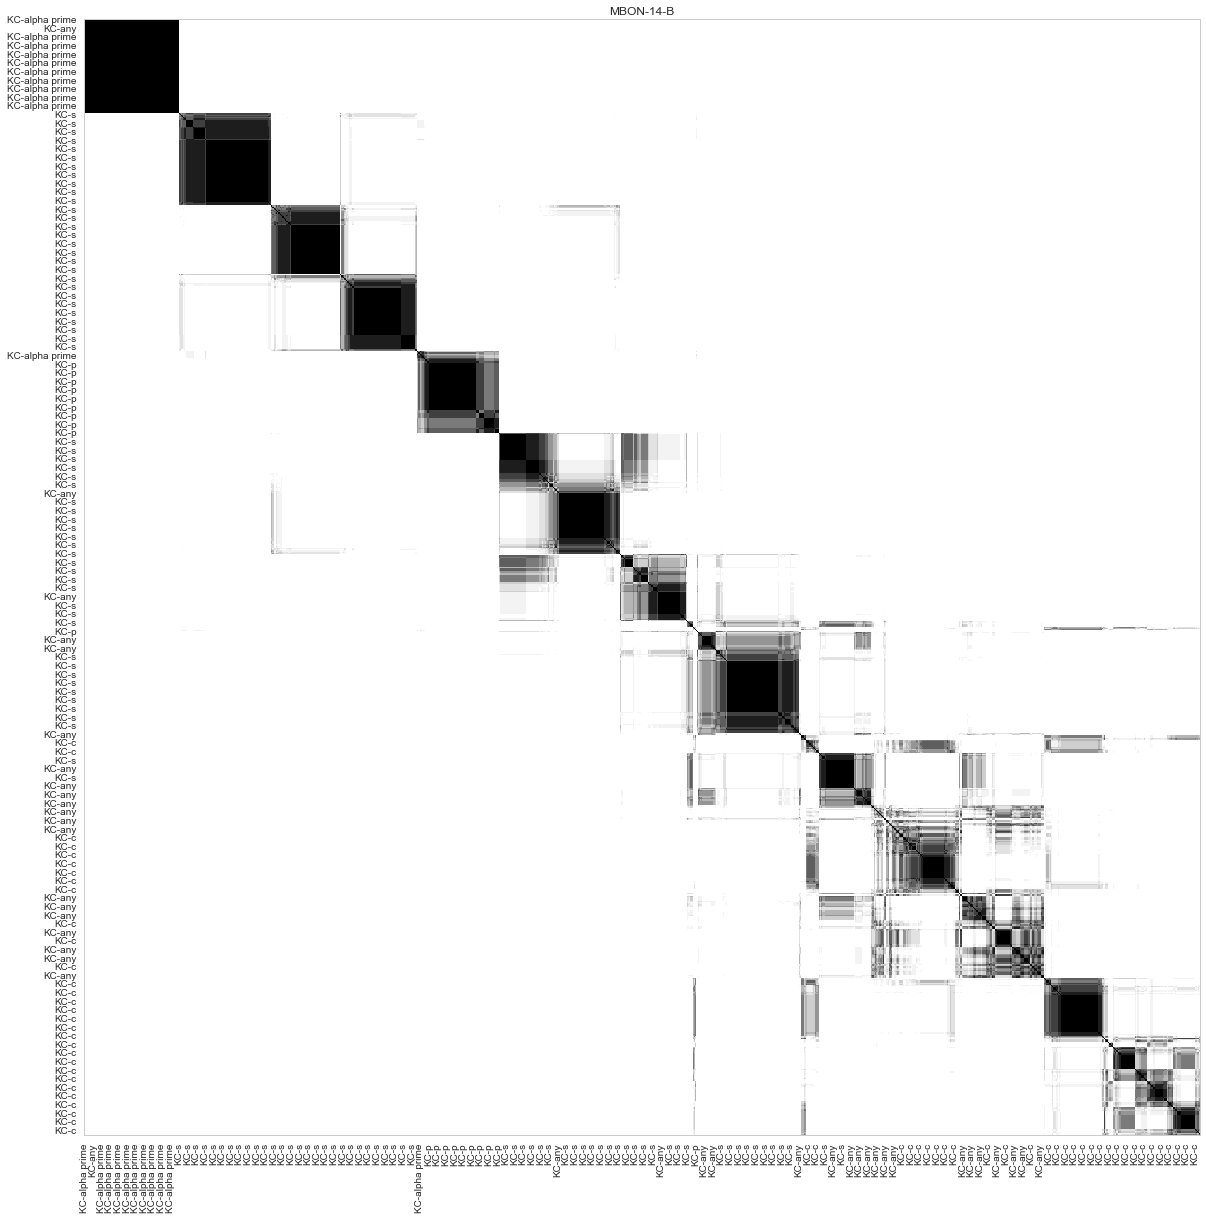

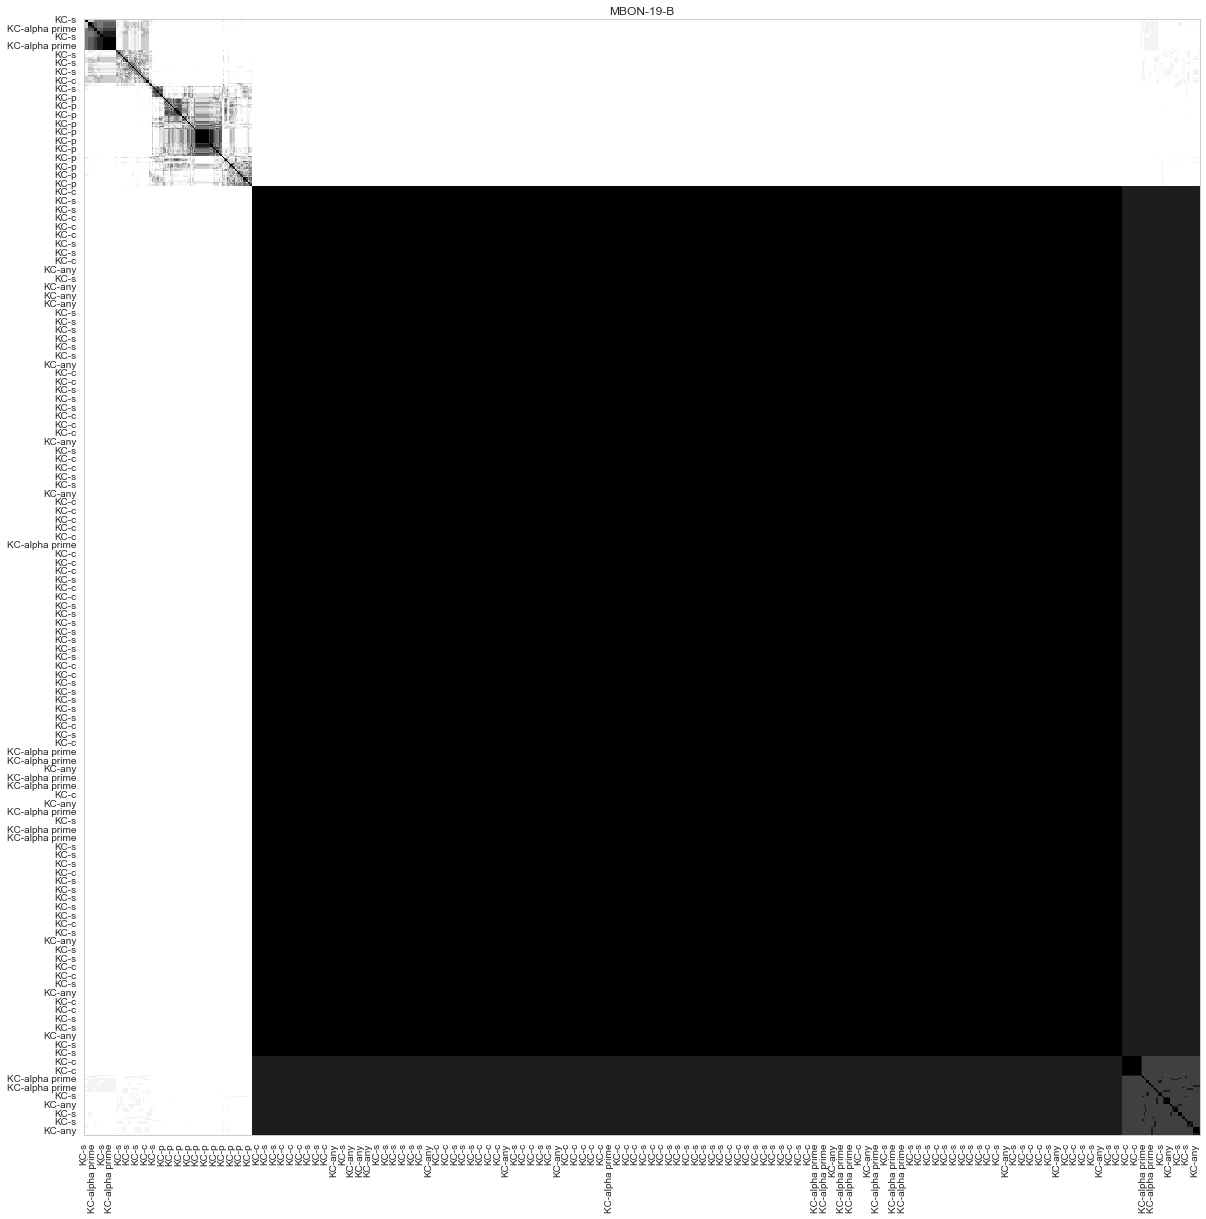

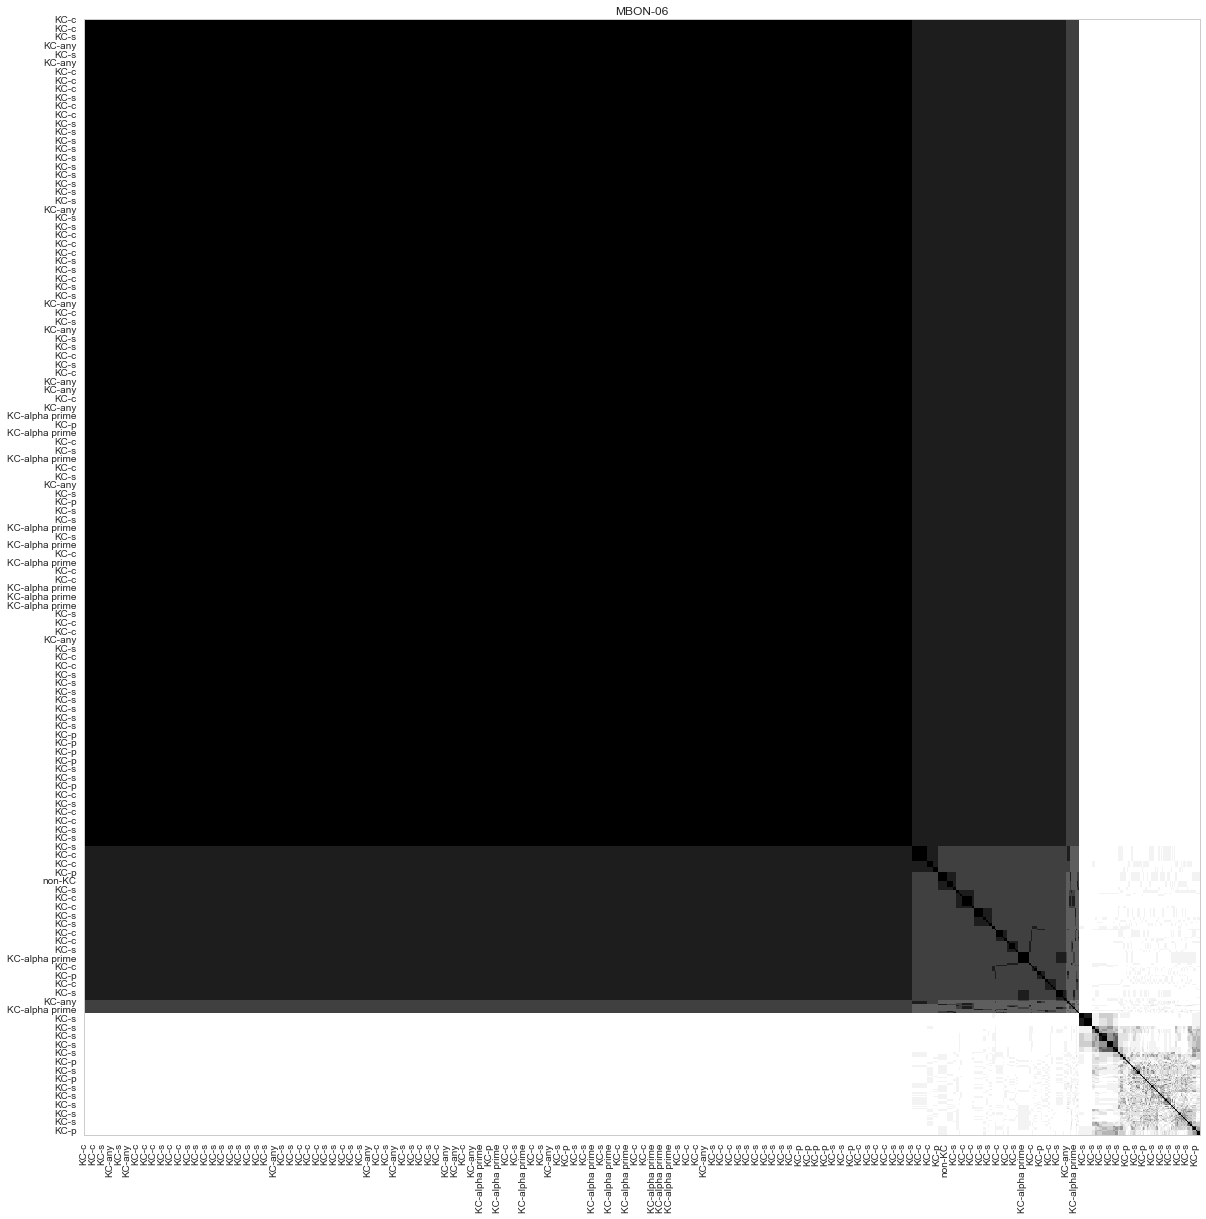

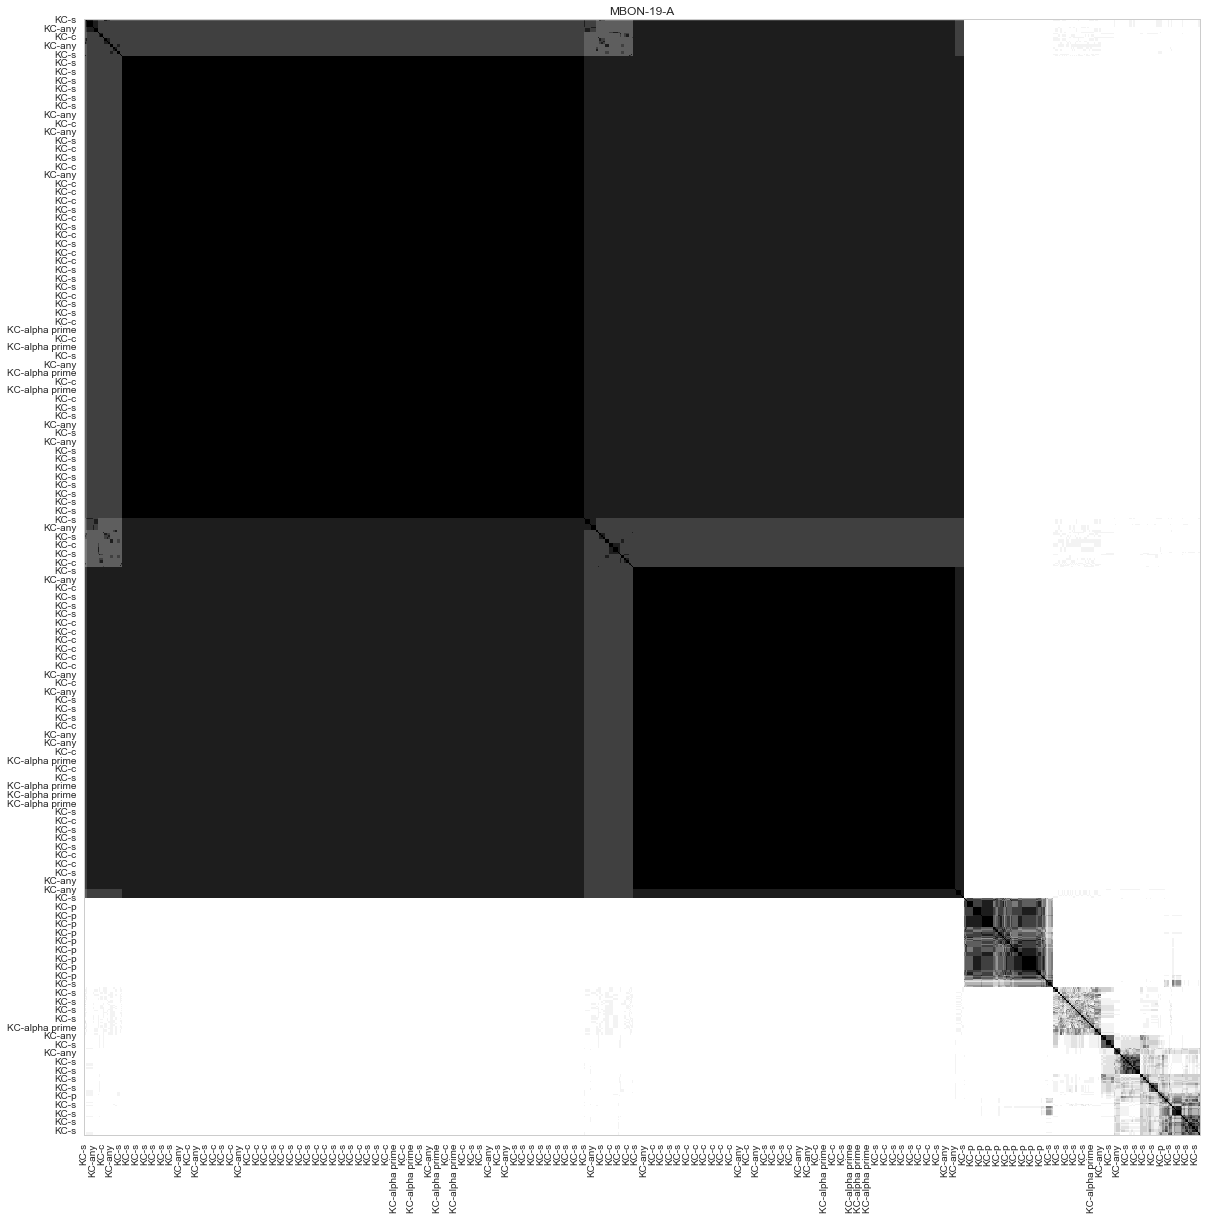

In [ ]:
for mbon_name, chains in mbon_chains.iteritems():
    fig = pylab.figure(figsize=(20, 20))
    ax = fig.add_subplot(1, 1, 1)


    av = [np.array(d['domains']['d1']['assignment']) for d in chains]
    z = irm.util.compute_zmatrix(av)    

    order = irm.plot.plot_zmatrix(ax, z)
    pre_ids_sorted = [pos_to_pre_ids[s] for s in order]
    labels_ordered = np.array([get_by_pre_id(id)['name'] for id in pre_ids_sorted])

    ticks = np.arange(0, KCN, 8)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels_ordered[ticks])
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels_ordered[ticks], rotation=90)
    #ax.set_yticks([])
    ax.set_title(mbon_name)
    ax.grid(False)
    fig.savefig("rosette sbm evaluate.%s.zmatrix.pdf" % mbon_name)

8566


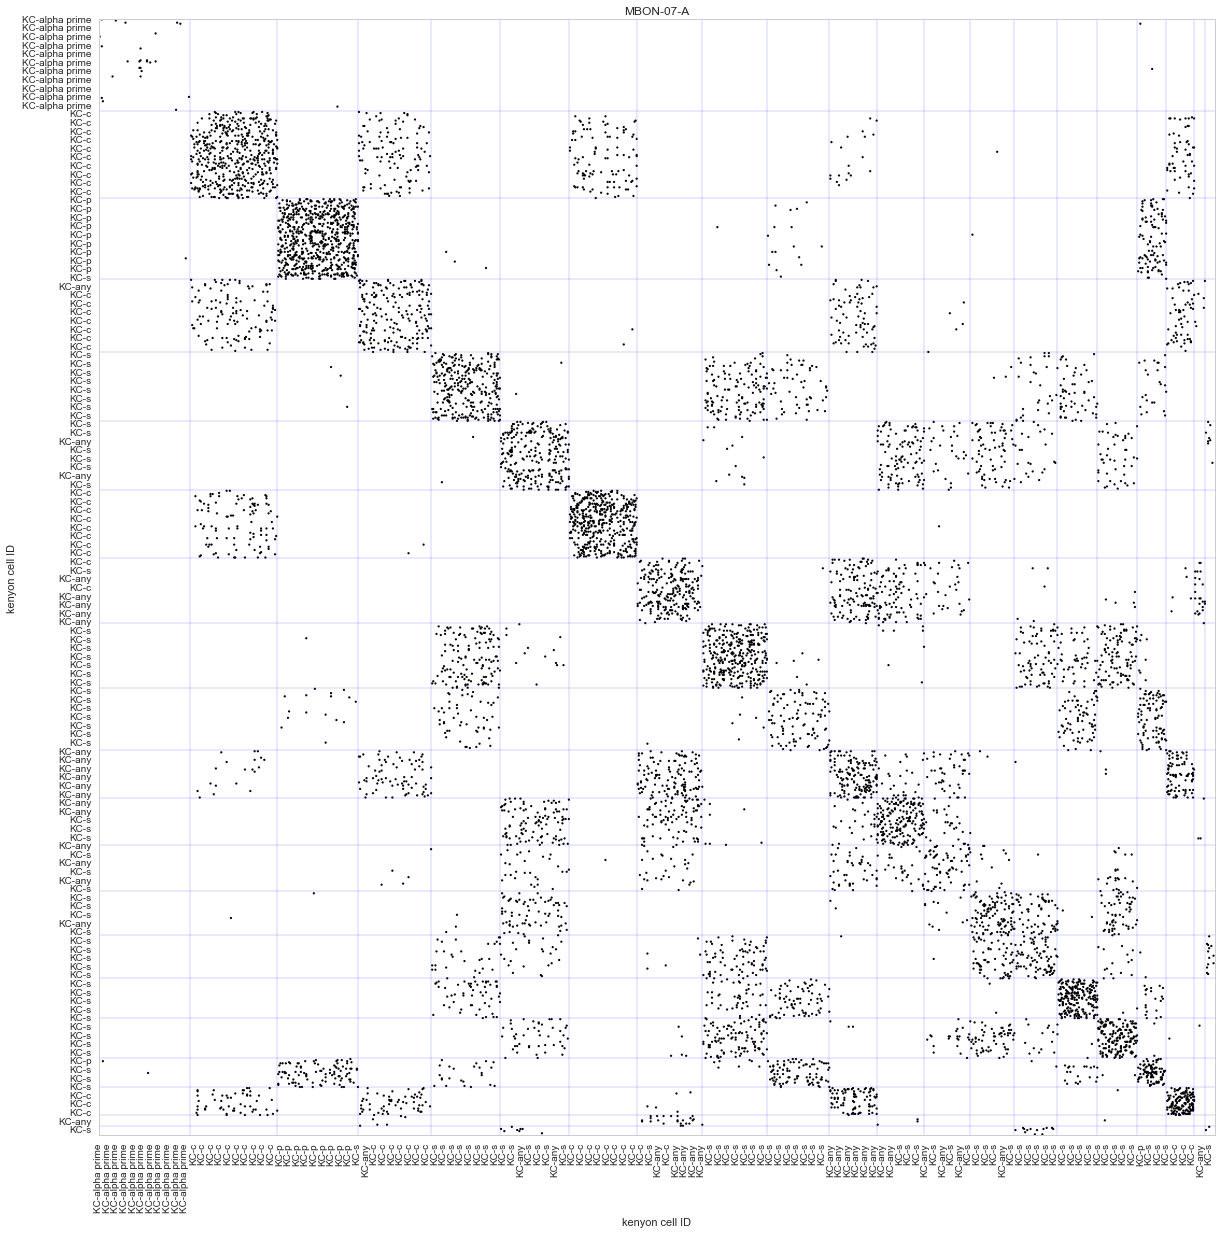

In [11]:


rosette_mat = kc_rosette_kc_mats[mbon_name]
conn_mat = rosette_mat[:, :, 2:].sum(axis=2)
sample_pos = 2

assignment = irm.util.canonicalize_assignment(chains[sample_pos]['domains']['d1']['assignment'])
sort_order = np.argsort(assignment.flatten())

pre_ids_sorted = [pos_to_pre_ids[s] for s in sort_order]
labels_ordered = np.array([get_by_pre_id(id)['name'] for id in pre_ids_sorted])


fig = pylab.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)

rosette_mat = kc_rosette_kc_mats[mbon_name]
conn_mat = rosette_mat[:, :, 2:].sum(axis=2)


conn_rand = conn_mat[sort_order]
conn_rand = conn_rand[:, sort_order]


a = np.argwhere(conn_rand)
print len(a)
counts = np.array([conn_rand[i, j] for i, j in a])
ax.scatter(a[:, 0], a[:, 1], edgecolor='none', c='k',
           s=5, #s=10*counts**2, 
           alpha=1)
ax.set_xlim(0, KCN)
ax.set_ylim(KCN, 0)

divisions = np.argwhere(np.diff(assignment[sort_order])).flatten()
for d in divisions:
    ax.axhline(d, c='b', alpha=0.1)
    ax.axvline(d, c='b', alpha=0.1)
    

ticks = np.arange(0, KCN, 8)
ax.set_yticks(ticks)
ax.set_yticklabels(labels_ordered[ticks])
ax.set_xticks(ticks)
ax.set_xticklabels(labels_ordered[ticks], rotation=90)
#ax.set_yticks([])
ax.set_title(mbon_name)
ax.grid(False)
ax.set_xlabel("kenyon cell ID")
ax.set_ylabel("kenyon cell ID")
fig.savefig('kc-rosette-kc.%s.%d.pdf' % (tgt_cell, sample_pos))

In [12]:
# aggregate statistics
chains = {}
for c in kc_rosette_kc_mats.keys():
    chains[c] = [pickle.load(open(td("KC-rosette-KC.%s.samples.%02d.pickle" %(c, i)))) for i in range(10)]


In [13]:
cell_times = []

for cell in chains.keys():
    cell_chain = chains[cell]
    alltimes = []
    for chain_i in range(len(cell_chain)):
        
        scores, state, times, _ = cell_chain[chain_i]['samples'][cell]
        iter_times = np.diff(times)
        alltimes.append(iter_times)
    df = pd.DataFrame({'iter_time' : np.concatenate(alltimes)})
    df['cell'] = cell
    cell_times.append(df)
timesdf = pd.concat(cell_times)

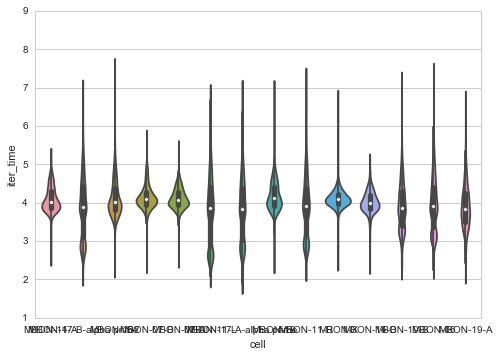

In [14]:
sns.violinplot(x='cell', y='iter_time', data=timesdf, size=18)

In [15]:
x = {}
x.copy()

{}